In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az
import xarray as xr

sns.set_style("whitegrid")

## Выбор одной из трех моделей

Краткое описание модели:
мы хотим исследовать состав молока у нескольких видов приматов, предполагается, что самки приматов с большим мозгом производят более питательное молоко (в общем, это предположение исходит из того, что развития большего объема мозга требуется более калорийное молоко). 

Это важный вопрос для эволючионного развития, и мы попытаемся дать и ответить на него. 

Мы будем использовать 3 переменные, две прогнозирующие переменные: доля неокортекса по сравнению с общей массой мозга (отвечает за высшие нервные функции, например речь) и  массы тела самки, а для прогнозируемой переменной, килокалорий на грамм молока. 

С этими переменными мы собираемся построить 3 различные линейные модели:

* Модель, использующая только процент неокортекса в коре головного мозга
* Модель, использующая только массу тела
* Модель с использованием обеих переменных

In [58]:

df = pd.read_csv('datasets/milk.csv', sep =';')
df = df.dropna().reset_index(drop=True)
display(df.tail(3))
display(df.describe())
df['neocortex']= df['neocortex.perc']/100

d = df[['kcal.per.g','neocortex','mass']].copy()

mn = d.iloc[:,1:].mean()
d.iloc[:,1:] = d.iloc[:,1:] - d.iloc[:,1:].mean() 
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
14,Ape,Pan paniscus,0.48,21.18,11.68,67.14,40.74,70.24
15,Ape,P troglodytes,0.55,36.84,9.54,53.62,33.11,76.30
16,Ape,Homo sapiens,0.71,50.49,9.84,39.67,54.95,75.49


,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.657647,36.063529,16.255294,47.681176,16.637647,67.575882
std,0.172899,14.705419,5.598480,13.585261,23.582322,5.968612
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000
25%,0.490000,27.180000,11.680000,37.800000,1.550000,64.540000
50%,0.620000,37.780000,15.800000,46.880000,5.250000,68.850000
75%,0.800000,50.490000,20.850000,55.200000,33.110000,71.260000
max,0.970000,55.510000,25.300000,70.770000,79.430000,76.300000


,kcal.per.g,neocortex,mass
0,0.49,-0.124159,-14.687647
1,0.47,-0.030359,-11.387647
2,0.56,-0.030359,-11.267647
3,0.89,0.000641,-14.127647
4,0.92,0.012741,-15.957647


In [4]:
with pm.Model() as model_0:
    neocortex_shared = pm.Data('neocortex',d['neocortex'].values)
    alpha = pm.Normal('α', mu=0, sigma=10)
    beta = pm.Normal('β', mu=0, sigma=1)
    sigma = pm.HalfNormal('σ', 10)

    mu = alpha + beta * neocortex_shared

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    trace_0 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

with pm.Model() as model_1:
    mass_shared = pm.Data('mass',d['mass'].values)   
    alpha = pm.Normal('α', mu=0, sigma=10)
    beta = pm.Normal('β', mu=0, sigma=1)
    sigma = pm.HalfNormal('σ', 10)

    mu = alpha + beta * mass_shared
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'], shape = mu.shape)

    trace_1 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

with pm.Model() as model_2:
    mass_shared = pm.Data('mass',d['mass'].values)
    neocortex_shared = pm.Data('neocortex',d['neocortex'].values)    
    alpha = pm.Normal('α', mu=0, sigma=10)
    beta = pm.Normal('β', mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal('σ', 10)

    mu = alpha + pm.math.dot(beta, [neocortex_shared,mass_shared])

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'], shape = mu.shape)

    trace_2 = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


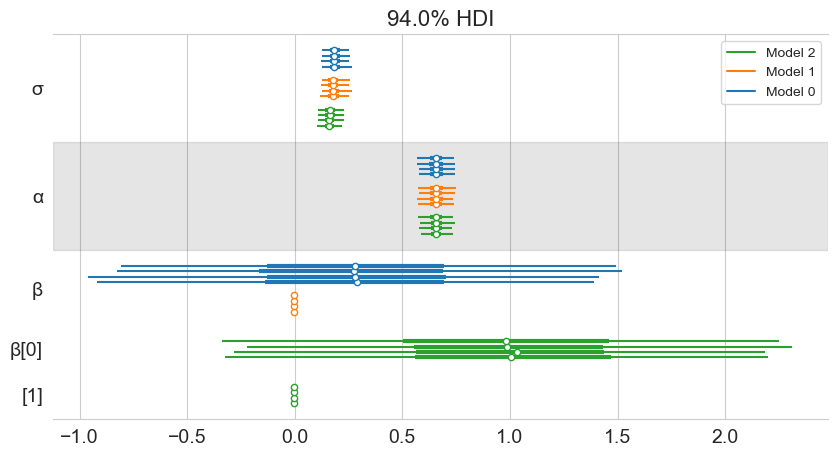

In [5]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

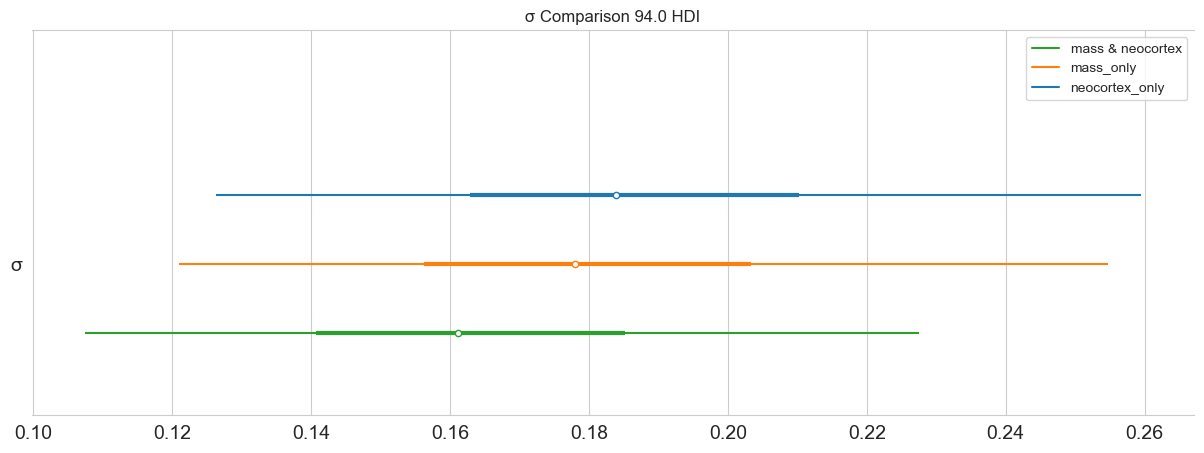

In [6]:
axes = az.plot_forest(
    traces,
    model_names=["neocortex_only", "mass_only", "mass & neocortex" ],
    var_names=["σ"], combined=True, figsize=(15, 5))
axes[0].set_title("σ Comparison 94.0 HDI");

In [7]:
model_dict = dict(zip(['model_0', 'model_1', 'model_2'], traces))
comp = az.compare(model_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2,0,6.048475,2.258819,0.000000,1.000000e+00,1.327447,0.000000,False,log
model_1,1,4.508304,1.939671,1.540171,2.775558e-16,1.686470,0.870232,False,log
model_0,2,3.987201,1.687385,2.061274,0.000000e+00,1.656968,1.034580,False,log


In [44]:
comp = az.compare(model_dict, ic ='waic', method = 'BB-pseudo-BMA')
comp

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_2,0,6.117351,2.189943,0.000000,0.701009,1.301579,0.000000,False,log
model_1,1,4.562184,1.885791,1.555167,0.179509,1.627282,0.861476,False,log
model_0,2,4.018546,1.656040,2.098805,0.119482,1.612801,1.033014,False,log


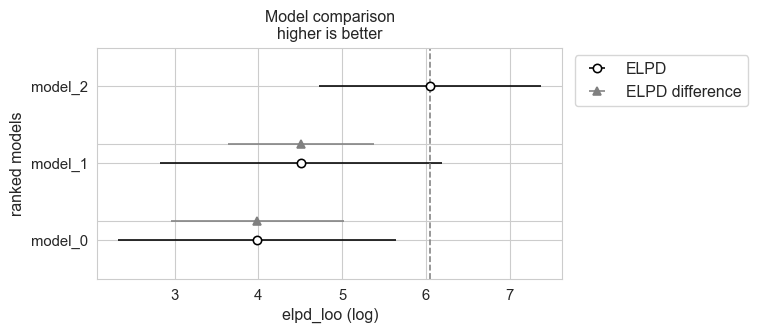

In [8]:
az.plot_compare(comp);

Мы можем видеть, что лучшая модель - модель_2, модель с двумя переменными. Обратите внимание, что DataFrame упорядочен от WAIC от меньшего к большему (т.е. от лучшей к худшей модели).

Мы также можем увидеть, что мы получаем столбец с относительным весом для каждой модели . 

Этот вес можно приблезительно интерпретировать - с какой вероятностью каждая модель сделает правильные прогнозы на будущих данных. 

Конечно, эта интерпретация зависит от моделей, используемых для вычисления весов, если мы добавим или удалим модели, веса будут меняться. А также зависит от предположений, лежащих в основе WAIC (или любого другого используемого критерия информации). Поэтому постарайтесь не переоценивать эти веса.


Теперь мы будем использовать совокупные веса для генерации прогнозов, основанных не на одной модели, а на взвешенном наборе моделей. 

Это один из способов усреднения модели. Используя PyMC, мы можем вызвать функцию `az.weight_predictions` следующим образом:

In [70]:
with model_1:
    sample_1 = pm.sample_posterior_predictive(trace_1,  var_names=['kcal'])

with model_2:
     sample_2 = pm.sample_posterior_predictive(trace_2,  var_names=['kcal'])

Sampling: [kcal]


Output()

Sampling: [kcal]


Output()

In [72]:
sample_w = az.weight_predictions([sample_1, sample_2], weights=[0.5, 0.5])

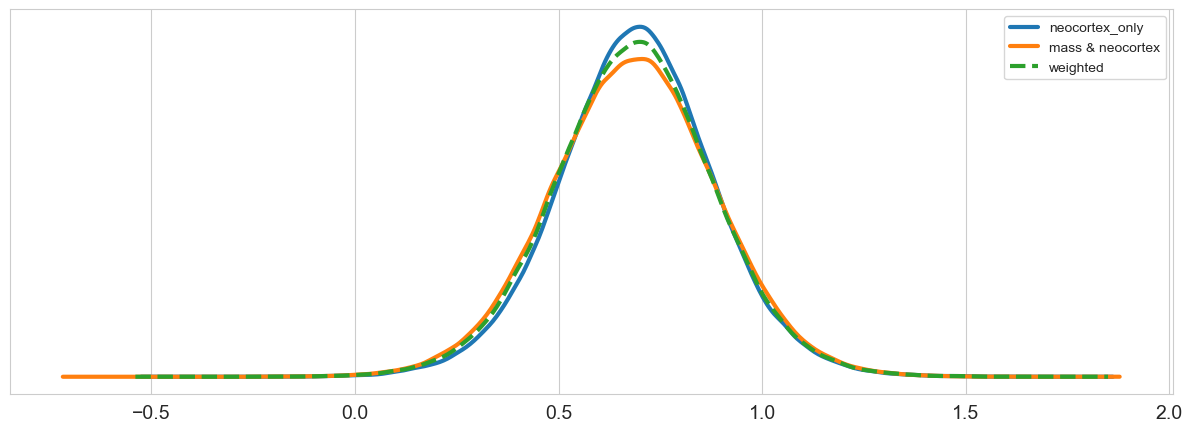

In [74]:
_, ax = plt.subplots(figsize=(15, 5))
az.plot_kde(
    sample_1.posterior_predictive["kcal"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="neocortex_only",
    ax=ax,
)
az.plot_kde(
    sample_2.posterior_predictive["kcal"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="mass & neocortex",
    ax=ax,
)
az.plot_kde(
    sample_w.posterior_predictive["kcal"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.yticks([])
plt.legend();

In [76]:
neocortex = np.linspace(0.5, 0.8, 30) - mn['neocortex']  # доля неокортекса
mass = np.full(30, 4.5) - mn['mass']                   # масса тела (одинакова)

with model_1:
    pm.set_data({
        'mass': mass,
    })
    post_pred_1 = pm.sample_posterior_predictive(
            trace = trace_1,
            var_names=["kcal"]
            )



with model_2:
    pm.set_data({
        'neocortex': neocortex,
        'mass': mass
    })
    post_pred_2 = pm.sample_posterior_predictive(
            trace = trace_2,
            var_names=["kcal"]
            )

sample_predict_weight = az.weight_predictions([post_pred_1, post_pred_2], weights=[0.25, 0.75])
            

Sampling: [kcal]


Output()

Sampling: [kcal]


Output()

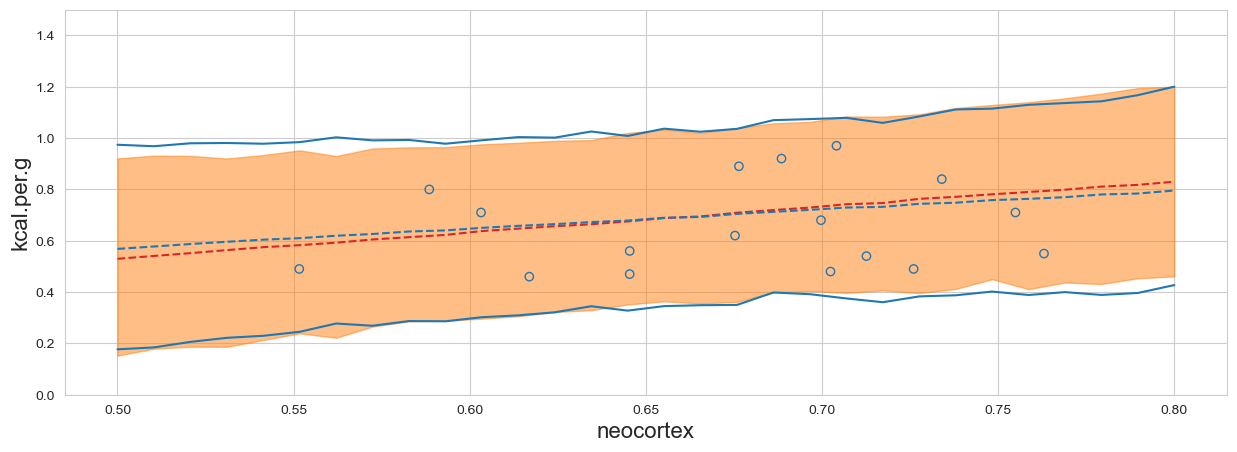

In [77]:
_, ax = plt.subplots(figsize=(15, 5))
ax.plot(neocortex+mn['neocortex'], post_pred_2.posterior_predictive["kcal"].mean(("chain", "draw")), 
        ls='--', color='C3')
az.plot_hdi(neocortex+mn['neocortex'], post_pred_2.posterior_predictive["kcal"], 
            hdi_prob=0.94, smooth=False, ax=ax)

ax.plot(neocortex+mn['neocortex'], sample_predict_weight.posterior_predictive["kcal"].mean('sample'), 
        ls='--', color='C0')

hdi_data_w = az.hdi(sample_predict_weight.posterior_predictive["kcal"], input_core_dims = [['sample']]) 

# az.plot_hdi(neocortex+mn['neocortex'], hdi_data = hdi_data_w, 
#             hdi_prob=0.94, smooth=False, ax=ax, color='C0', 
#             fill_kwargs={'alpha': 0.3})

plt.plot(neocortex+mn['neocortex'], hdi_data_w['kcal'], color='C0')

plt.scatter(d['neocortex']+mn['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0, 1.5)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);